# Parallel ViT-CNN Hybrid with HAM10000

We start with GPU availability check.

In [1]:
import tensorflow as tf
import torch

print(f"Tensorflow Version: {tf.__version__}")
print(f"TF GPU Available: {tf.config.list_physical_devices('GPU')}")

print(f"\nPyTourch Version: {torch.__version__}")
print(f"PyTourch GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

Tensorflow Version: 2.20.0
TF GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PyTourch Version: 2.10.0+cu128
PyTourch GPU Available: True
Device Name: NVIDIA GeForce RTX 4070 Laptop GPU


We define the HAM10000 dataset,

In [2]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder

class HAM10000Manager:
    def __init__(self, csv_file, img_dir):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir

        # 1. Encode Labels
        self.encoder = LabelEncoder()
        self.df['label'] = self.encoder.fit_transform(self.df['dx'])

        # 2. Map image IDs to actual file paths
        self.image_paths = {os.path.splitext(f)[0]: os.path.join(img_dir, f)
                           for f in os.listdir(img_dir)}

    def get_splits(self, train_size=0.8, val_size=0.1, test_size=0.1):
        """
        Splits data using lesion_id to prevent data leakage.
        """
        # First split: Train vs (Val + Test)
        gss_main = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
        train_idx, temp_idx = next(gss_main.split(self.df, groups=self.df['lesion_id']))

        train_df = self.df.iloc[train_idx]
        temp_df = self.df.iloc[temp_idx]

        # Second split: Val vs Test from the remaining data
        # Calculate relative size: 0.1 / (0.1 + 0.1) = 0.5
        relative_val_size = val_size / (val_size + test_size)
        gss_val = GroupShuffleSplit(n_splits=1, train_size=relative_val_size, random_state=42)
        val_idx, test_idx = next(gss_val.split(temp_df, groups=temp_df['lesion_id']))

        val_df = temp_df.iloc[val_idx]
        test_df = temp_df.iloc[test_idx]

        return train_df, val_df, test_df

class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, image_path_map, transform=None):
        self.df = dataframe
        self.image_paths = image_path_map
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['image_id']
        img_path = self.image_paths[img_id]
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

.. and define custom resize transformation,

In [3]:
from torchvision import transforms
import torchvision.transforms.functional as F

class LetterboxResize:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size

    def __call__(self, img):
        # 1. Resize the image such that the longest side matches target_size
        w, h = img.size
        max_side = max(self.target_size)
        scale = max_side / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        img = F.resize(img, (new_h, new_w))

        # 2. Pad the shorter side to make it square
        delta_w = self.target_size[0] - new_w
        delta_h = self.target_size[1] - new_h
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

        # Use a constant background color (black or gray)
        return F.pad(img, padding, fill=0, padding_mode='constant')

.. and from such definition, we instantiate datasets.

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Initialize Manager
manager = HAM10000Manager('/tf/data/ham10k_metadata.csv', '/tf/data/ham10k_images')
train_df, val_df, test_df = manager.get_splits()

# Define Transforms
train_transform = transforms.Compose([
    LetterboxResize(target_size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Dataset Objects
train_ds = HAM10000Dataset(train_df, manager.image_paths, transform=train_transform)
val_ds = HAM10000Dataset(val_df, manager.image_paths, transform=val_test_transform)
test_ds = HAM10000Dataset(test_df, manager.image_paths, transform=val_test_transform)

# Create Loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")

Train size: 7991 | Val size: 1025 | Test size: 999


We define training step,

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        # Conformer outputs: [logits_cnn, logits_trans]
        out_cnn, out_trans = model(images)

        # Combined loss as suggested in Conformer paper
        loss = criterion(out_cnn, labels) + criterion(out_trans, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # For accuracy, we usually average the predictions or use the transformer head
        prediction = (out_cnn + out_trans).argmax(dim=1)
        correct += (prediction == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

.. and validation step,

In [6]:
import torch
import torch.nn as nn
from tqdm import tqdm 

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            out_cnn, out_trans = model(images)
            loss = criterion(out_cnn, labels) + criterion(out_trans, labels)

            total_loss += loss.item()
            prediction = (out_cnn + out_trans).argmax(dim=1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

.. silence warning

In [7]:
import warnings
warnings.filterwarnings("ignore")

.. and perform training

In [8]:
import torch
import torch.nn as nn
from tqdm import tqdm

import sys
import os

# Get the absolute path to your Conformer folder
path_to_conformer = os.path.abspath('./Conformer')

# Add it to the system path
if path_to_conformer not in sys.path:
    sys.path.insert(0, path_to_conformer)

from models import Conformer_small_patch16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Conformer_small_patch16(num_classes=7).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

best_val_acc = 0.0

for epoch in range(3):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_conformer_ham.pth')
        print("  --> Model Checkpointed!")

Training: 100% 250/250 [16:57<00:00,  4.07s/it]
Validating: 100% 33/33 [00:18<00:00,  1.82it/s]


Epoch 0:
  Train Loss: 1.9271 | Acc: 67.30%
  Val Loss:   2.0831 | Acc: 64.98%
  --> Model Checkpointed!


Training: 100% 250/250 [16:04<00:00,  3.86s/it]
Validating: 100% 33/33 [00:16<00:00,  1.99it/s]


Epoch 1:
  Train Loss: 1.6395 | Acc: 70.62%
  Val Loss:   1.9314 | Acc: 64.59%


Training: 100% 250/250 [16:07<00:00,  3.87s/it]
Validating: 100% 33/33 [00:16<00:00,  1.99it/s]


Epoch 2:
  Train Loss: 1.5240 | Acc: 72.17%
  Val Loss:   1.7146 | Acc: 70.24%
  --> Model Checkpointed!


Training: 100% 250/250 [16:04<00:00,  3.86s/it]
Validating: 100% 33/33 [00:16<00:00,  1.99it/s]


Epoch 3:
  Train Loss: 1.4651 | Acc: 73.68%
  Val Loss:   1.6852 | Acc: 69.76%


Training: 100% 250/250 [16:04<00:00,  3.86s/it]
Validating: 100% 33/33 [00:16<00:00,  2.01it/s]


Epoch 4:
  Train Loss: 1.3942 | Acc: 75.00%
  Val Loss:   1.6607 | Acc: 72.20%
  --> Model Checkpointed!


Training: 100% 250/250 [16:04<00:00,  3.86s/it]
Validating: 100% 33/33 [00:16<00:00,  2.02it/s]


Epoch 5:
  Train Loss: 1.3624 | Acc: 75.32%
  Val Loss:   1.6289 | Acc: 72.59%
  --> Model Checkpointed!


Training: 100% 250/250 [16:04<00:00,  3.86s/it]
Validating: 100% 33/33 [00:16<00:00,  1.96it/s]


Epoch 6:
  Train Loss: 1.3229 | Acc: 76.22%
  Val Loss:   1.5820 | Acc: 73.37%
  --> Model Checkpointed!


Training: 100% 250/250 [16:27<00:00,  3.95s/it]
Validating: 100% 33/33 [00:21<00:00,  1.52it/s]


Epoch 7:
  Train Loss: 1.2904 | Acc: 76.77%
  Val Loss:   1.6292 | Acc: 71.51%


Training: 100% 250/250 [1:04:46<00:00, 15.55s/it] 
Validating: 100% 33/33 [00:16<00:00,  1.99it/s]


Epoch 8:
  Train Loss: 1.2477 | Acc: 78.04%
  Val Loss:   1.5702 | Acc: 72.59%


Training: 100% 250/250 [16:34<00:00,  3.98s/it]
Validating: 100% 33/33 [00:29<00:00,  1.11it/s]


Epoch 9:
  Train Loss: 1.2307 | Acc: 77.77%
  Val Loss:   1.7113 | Acc: 72.10%


Training: 100% 250/250 [17:38<00:00,  4.23s/it]
Validating: 100% 33/33 [00:17<00:00,  1.89it/s]


Epoch 10:
  Train Loss: 1.1975 | Acc: 78.28%
  Val Loss:   1.6176 | Acc: 72.78%


Training:  74% 184/250 [12:21<04:25,  4.03s/it]


KeyboardInterrupt: 

We evaluate model by plotting confusion matrix,

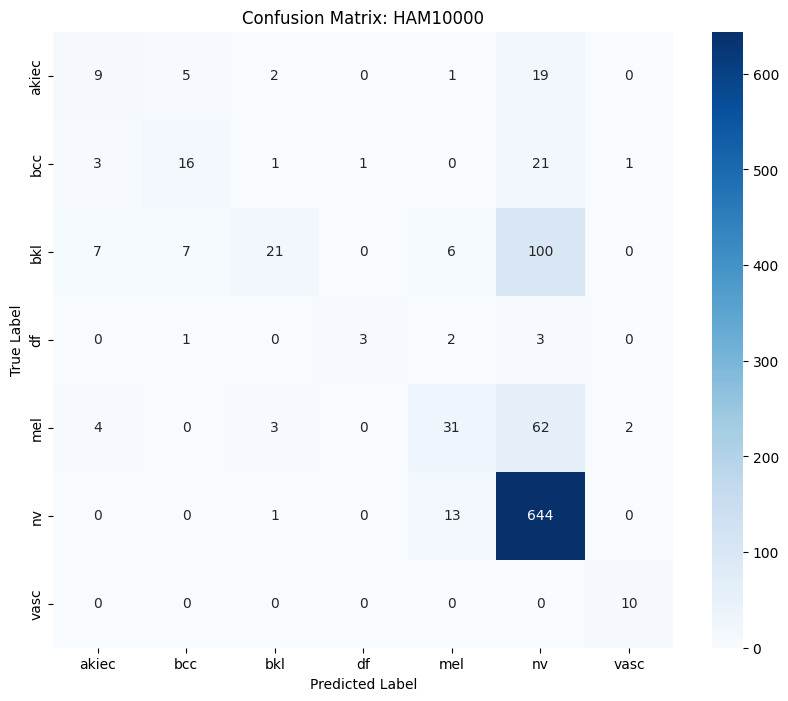


Classification Report:

              precision    recall  f1-score   support

       akiec       0.39      0.25      0.31        36
         bcc       0.55      0.37      0.44        43
         bkl       0.75      0.15      0.25       141
          df       0.75      0.33      0.46         9
         mel       0.58      0.30      0.40       102
          nv       0.76      0.98      0.85       658
        vasc       0.77      1.00      0.87        10

    accuracy                           0.73       999
   macro avg       0.65      0.48      0.51       999
weighted avg       0.72      0.73      0.68       999



In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            # Conformer dual-output handling: average the branches for prediction
            out_cnn, out_trans = model(images)
            outputs = (out_cnn + out_trans) / 2

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: HAM10000')
    plt.show()

    # Also print the detailed F1-score/Recall report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Usage:
# Get names from the encoder we defined in the Manager class
class_names = manager.encoder.classes_
plot_confusion_matrix(model, test_loader, DEVICE, class_names)

.. also plot PR-curve,

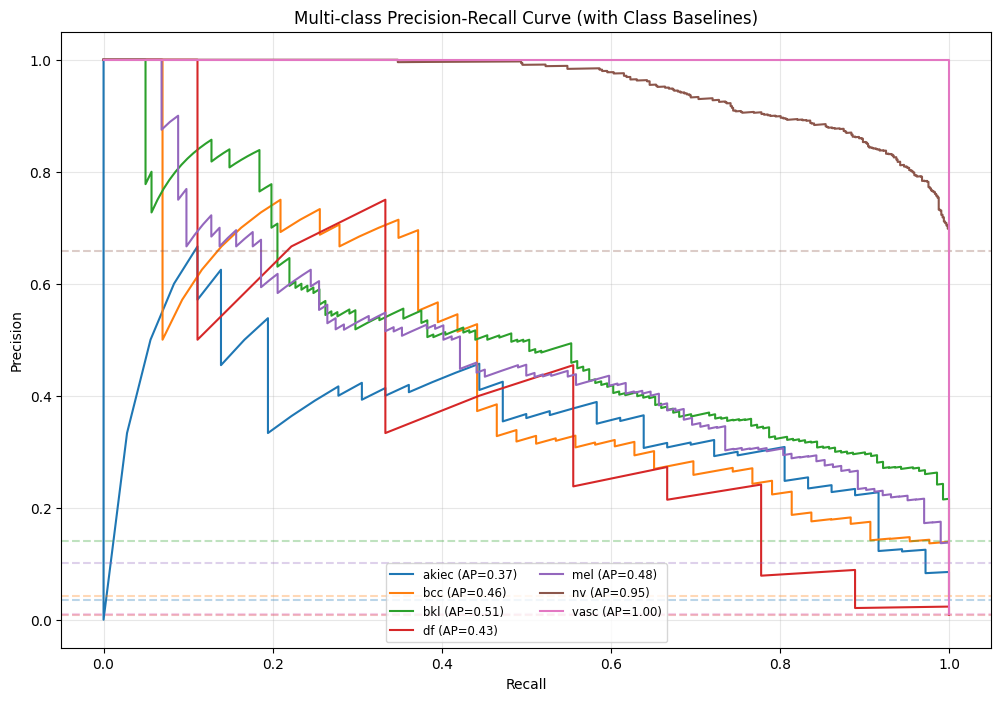

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_pr_curve(model, loader, device, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            out_cnn, out_trans = model(images)
            # Use averaged probabilities for the curve
            probs = torch.softmax((out_cnn + out_trans) / 2, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())

    Y_test = label_binarize(np.concatenate(all_labels), classes=range(len(class_names)))
    Y_score = np.concatenate(all_probs)
    n_classes = len(class_names)

    plt.figure(figsize=(12, 8))

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(Y_test[:, i], Y_score[:, i])
        ap_score = average_precision_score(Y_test[:, i], Y_score[:, i])

        # Calculate baseline (prevalence of class i)
        baseline = np.sum(Y_test[:, i]) / len(Y_test)

        line, = plt.plot(recall, precision, label=f'{class_names[i]} (AP={ap_score:.2f})')
        # Draw dashed baseline with the same color as the curve
        plt.axhline(y=baseline, color=line.get_color(), linestyle='--', alpha=0.3)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall Curve (with Class Baselines)')
    plt.legend(loc='best', fontsize='small', ncol=2)
    plt.grid(alpha=0.3)
    plt.show()

# Usage:
plot_pr_curve(model, test_loader, DEVICE, manager.encoder.classes_)

.. and AUC PR

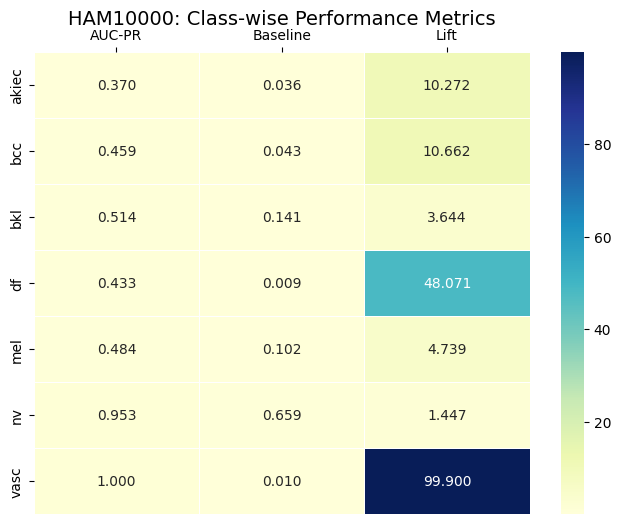

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

def plot_styled_auc_table(model, loader, device, class_names):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            out_cnn, out_trans = model(images)
            probs = torch.softmax((out_cnn + out_trans) / 2, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())

    Y_test = label_binarize(np.concatenate(all_labels), classes=range(len(class_names)))
    Y_score = np.concatenate(all_probs)

    # 1. Generate Metrics
    data = []
    for i, name in enumerate(class_names):
        auc_pr = average_precision_score(Y_test[:, i], Y_score[:, i])
        baseline = np.sum(Y_test[:, i]) / len(Y_test)
        lift = auc_pr / baseline if baseline > 0 else 0
        data.append([auc_pr, baseline, lift])

    # 2. Create DataFrame for Seaborn
    df_metrics = pd.DataFrame(data, index=class_names, columns=['AUC-PR', 'Baseline', 'Lift'])

    # 3. Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_metrics, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, linewidths=.5)

    plt.title('HAM10000: Class-wise Performance Metrics', pad=20, fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=True, labeltop=True)
    plt.show()

# Usage
plot_styled_auc_table(model, test_loader, DEVICE, manager.encoder.classes_)